# LOL Win Prediction from First 10 Minutes Game Play Data
- Author: Shawn Jung (shawnagie@gmail.com) <br> 
- Last Update: 4/22/2020 <br>
This is a fun, pebble project to build a win/lose prediction model based on first ten minutes of Legue of Legends game data. FYI, the game is a multiplayer online battle game developed by Riot Games, which is a de-facto national sport in South Korea. I got this data from this Kaggle page. https://www.kaggle.com/bobbyscience/league-of-legends-diamond-ranked-games-10-min If you are interested in the game itself, visit https://play.na.leagueoflegends.com/en_US

### Loading basic libraries

In [94]:
# pandas and numpy 
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 

# metrics and dataset prepration 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
#from sklearn.compose import ColumnTransformer 
#from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import MinMaxScaler 
from sklearn.decomposition import PCA 
from sklearn.metrics import classification_report 
from sklearn.pipeline import Pipeline 

# loading classifier libraries 
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC 

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

### Let's get the dataframe
An imputed dataframe will be defined based on separate EDA - df_imputed

In [26]:
pd.set_option('display.max_columns', None)

filepath = './data/high_diamond_ranked_10min.csv'
df = pd.read_csv(filepath)

In [27]:
df.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0,15,6,0,6,9,8,0,0,0,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2,12,1,1,5,5,2,2,1,1,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3,15,3,1,11,7,14,0,0,0,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,1,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7,15,2,1,5,4,10,0,0,0,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,0,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0,17,2,1,6,6,7,1,1,0,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [28]:
# It seems that there is no missing data
df.isnull().sum().any()

False

In [29]:
# Win and Lose are balanced. What a pretty and neat dataset! 
df.groupby(by='blueWins').size()

blueWins
0    4949
1    4930
dtype: int64

### Feature Engineering 
It appears that I might as well apply binning for some features. <BR> For instance, the Wards grants sights on the game map, and I see weirdly high outliers while 75% quantile ward numbers are 20. Considering median value 16 and the game behavior, it makes sense to transform such variables into ordinal values

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025827E62908>,
      dtype=object)

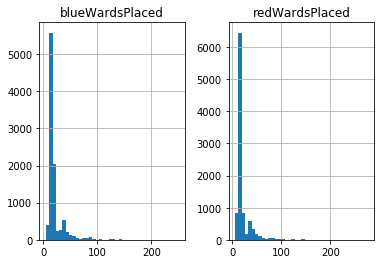

In [30]:
df[['blueWardsPlaced', 'redWardsPlaced']].hist(bins=40)

In [31]:
df[['blueWardsPlaced', 'redWardsPlaced']].describe()

,blueWardsPlaced,redWardsPlaced
count,9879.000000,9879.000000
mean,22.288288,22.367952
std,18.019177,18.457427
min,5.000000,6.000000
25%,14.000000,14.000000
50%,16.000000,16.000000
75%,20.000000,20.000000
max,250.000000,276.000000


In [32]:
# quantizing four variables 
df['blueWardsPlaced'] = pd.qcut(df['blueWardsPlaced'], 4, labels=False)
df['redWardsPlaced'] = pd.qcut(df['redWardsPlaced'], 4, labels=False)
df['blueWardsDestroyed'] = pd.qcut(df['blueWardsDestroyed'], 4, labels=False)
df['redWardsDestroyed'] = pd.qcut(df['redWardsDestroyed'], 4, labels=False)


In [33]:
df.groupby(by='blueWardsPlaced').size()

blueWardsPlaced
0    2508
1    2472
2    2590
3    2309
dtype: int64

In [35]:
df.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,3,1,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0,1,3,0,6,9,8,0,0,0,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,0,0,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2,0,0,1,5,5,2,2,1,1,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,1,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3,1,2,1,11,7,14,0,0,0,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,3,0,0,4,5,5,1,0,1,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7,1,1,1,5,4,10,0,0,0,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,3,2,0,6,6,6,0,0,0,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0,2,1,1,6,6,7,1,1,0,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


### Scaling continous Numeric Variables 
Some features do show good normal distribution, so it will be a good idea to standardize or scale them. But considering various ordinal variables, I will take the normalization route. From the domain knowledge, '# of Elite Monsters killed by red team' should be important though the numeric value per se is just 1 or 2. As we can use Euclidean distances for some models, the normalization would help get reasonable distance. 


The test strategy I take will be, spling the dataset into 'train' and 'test' sets, and applying Cross Validation onto 'train' when selecting and tuning classifiers. The final validation will be done against the test set. The normalization fitting will be done with 'train dataset' to avoid any leakage to test dataset

In [43]:
X = df.drop(['gameId','blueWins'], axis=1).values
y = df['blueWins'].values
test_size = 0.2 
seed = 42 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=seed, stratify=y)

In [60]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

PCA dimension reduction also looks good. Ten principal components can explain over 91% of variance. 

In [75]:
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(pca.explained_variance_ratio_.sum())

0.9157374341568627


In [76]:
pca.explained_variance_ratio_

array([0.26771445, 0.17999527, 0.0887853 , 0.08040262, 0.06850223,
       0.05978576, 0.05662712, 0.04083395, 0.03757806, 0.03551265])

In [45]:
# I might want to try StandardScaler later. So keeping this here 
# standardization_columns = ['blueKills', 'redKills', 'blueDeaths', 'redDeaths', 'blueAssists', 'redAssists', 'blueTotalGold', 'redTotalGold', 'blueAvgLevel', 'redAvgLevel', 'blueTotalExperience', 'redTotalExperience', 'blueTotalMinionsKilled', 'redTotalMinionsKilled', 'blueTotalJungleMinionsKilled', 'redTotalJungleMinionsKilled', 'blueGoldDiff', 'redGoldDiff', 'blueExperienceDiff', 'redExperienceDiff', 'blueCSPerMin', 'redCSPerMin', 'blueGoldPerMin', 'redGoldPerMin']

# ct_scaler = ColumnTransformer([('Scaling', StandardScaler(), standardization_columns)], remainder='passthrough')


### Model Spotcheck 
I will try a few classification models with default setting, and choose two to dig deeper 

In [46]:
models = []
models.append(('LogR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('TREE', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))

In [39]:
# Baseline modeling with non-scaled train data
accuracy_results = []
model_names = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    accuracy_results.append(cv_results)
    model_names.append(name)

    print('%s accuracy: %f (std %f)' % (name, cv_results.mean(), cv_results.std())) 

LogR accuracy: 0.735673 (std 0.013346)
LDA accuracy: 0.732889 (std 0.012687)
KNN accuracy: 0.688099 (std 0.020084)
TREE accuracy: 0.636849 (std 0.022592)
NB accuracy: 0.729093 (std 0.016527)
SVM accuracy: 0.500949 (std 0.000425)


In [47]:
# Spot check with scaled train data 
accuracy_results = []
model_names = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring='accuracy')
    accuracy_results.append(cv_results)
    model_names.append(name)

    print('%s accuracy: %f (std %f)' % (name, cv_results.mean(), cv_results.std())) 

LogR accuracy: 0.734913 (std 0.010945)
LDA accuracy: 0.732889 (std 0.012687)
KNN accuracy: 0.671395 (std 0.019718)
TREE accuracy: 0.636087 (std 0.018434)
NB accuracy: 0.729346 (std 0.016073)
SVM accuracy: 0.732128 (std 0.010219)


In [77]:
# Spot check with PCA scaled train data 
accuracy_results = []
model_names = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, X_train_pca, y_train, cv=kfold, scoring='accuracy')
    accuracy_results.append(cv_results)
    model_names.append(name)

    print('%s accuracy: %f (std %f)' % (name, cv_results.mean(), cv_results.std())) 

LogR accuracy: 0.727321 (std 0.014167)
LDA accuracy: 0.725043 (std 0.013025)
KNN accuracy: 0.670635 (std 0.012886)
TREE accuracy: 0.634824 (std 0.016451)
NB accuracy: 0.723147 (std 0.014545)
SVM accuracy: 0.722767 (std 0.011906)


It appears that Logistic Regression showed consistent, high accuracy with less deviation. So the next step will be tuning parameters with GridSearch <BR> 
### Find the best parameters with LR

In [85]:
# create regularization parameter space 
C = np.logspace(-4, 4, 50)
penalty = ['l1', 'l2', 'elasticnet']
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
params = dict(C=C, penalty=penalty, solver=solver)
lr_model = LogisticRegression()
kfold = StratifiedKFold(n_splits=10, random_state=seed) 
grid = GridSearchCV(estimator=lr_model, param_grid=params, scoring='accuracy', cv=kfold, iid=True, random_state=seed)

In [86]:
grid_result = grid.fit(X_train_scaled, y_train)

In [87]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.736303 using {'C': 1.2067926406393288, 'penalty': 'l1', 'solver': 'liblinear'}


In [89]:
grid_result.best_params_['C']

1.2067926406393288

The validation results shows balanced accuracy, recall and precision result. But I don't see much lift compared to spot-check result. The score remains around 72 

In [90]:
lr_final_model = LogisticRegression(C=grid_result.best_params_['C'], penalty=grid_result.best_params_['penalty'], solver=grid_result.best_params_['solver'])
lr_final_model.fit(X_train_scaled, y_train)
y_hat = lr_final_model.predict(X_test_scaled)

print(classification_report(y_test, y_hat))

precision    recall  f1-score   support

           0       0.72      0.71      0.72       990
           1       0.71      0.72      0.72       986

    accuracy                           0.72      1976
   macro avg       0.72      0.72      0.72      1976
weighted avg       0.72      0.72      0.72      1976



Applying Ensemble methods would not help much. I already see CART didn't do a good job at the spot check stage 

In [95]:
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier(n_estimators=10)))
ensembles.append(('ET', ExtraTreesClassifier(n_estimators=10)))
results = []
names = []
for name, model in ensembles:
	kfold = StratifiedKFold(n_splits=10, random_state=seed) 
	cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s accuracy: %f (std %f)' % (name, cv_results.mean(), cv_results.std())) 

AB accuracy: 0.724288 (std 0.012013)
GBM accuracy: 0.729472 (std 0.010989)
RF accuracy: 0.698597 (std 0.019198)
ET accuracy: 0.700874 (std 0.019072)


### Re-thinking Features 
Let's revisit the data again, and refine the features. Playing LoL would also help to deepend the domain knowledge. :) 
<BR> (to be continued)